In [1]:
import cv2
import torch.utils.data as dataf
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import lr_scheduler
import time as time
import datetime
import sys
from torchvision.utils import save_image
import csv
import random
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from forword import *
from unet import *
from utils import *
from torch.optim import Adam
import matplotlib.pyplot as plt

In [2]:
dtype = 'float32'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.set_default_tensor_type(torch.FloatTensor)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
training_x = []
path = './data/train/'  # 要改
path_list = os.listdir(path)
path_list.sort(key=lambda x: int(x.split('.')[0]))
for item in path_list:
    impath = path + item
    imgx = cv2.imread(path + item)
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    training_x.append(imgx)

X_train = []

for features in training_x:
    X_train.append(features)


X_train = np.array(X_train)
X_train=X_train.astype(dtype)
X_train= torch.from_numpy(X_train)
X_train=X_train.permute(0,3,1,2)
X_train=X_train/255.0
print(X_train.shape)

torch.Size([49500, 3, 32, 32])


In [4]:
test_x = []
path = './data/test/'  # 要改
path_list = os.listdir(path)
path_list.sort(key=lambda x: int(x.split('.')[0]))
for item in path_list:
    impath = path + item
    # print("开始处理"+impath)
    imgx = cv2.imread(path + item)
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    # imgy=imgy/255.0
    test_x.append(imgx)

x_test = []

for features in test_x:
    x_test.append(features)

x_test = np.array(x_test)
# X_train = np.array(X_train)
x_test=x_test.astype(dtype)
x_test= torch.from_numpy(x_test)
x_test=x_test.permute(0,3,1,2)
x_test=x_test/255.0
print(x_test.shape)

torch.Size([500, 3, 32, 32])


In [5]:
batch_size = 128
train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True,drop_last=True,num_workers=2)
test_loader = DataLoader(x_test, batch_size=batch_size, drop_last=True, num_workers=2)

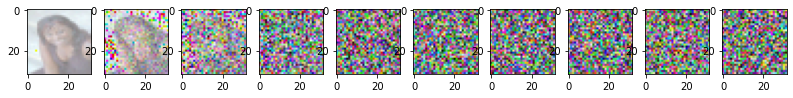

In [6]:
#模拟正向扩散过程
# 界定测试时间表
image = next(iter(train_loader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [7]:
model = SimpleUnet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 600

[Epoch 0/600] [Batch 0/386][Loss: 0.812039] ETA: 7 days, 17:23:42.877407Epoch 0 | step 000 Loss: 0.8120388984680176 


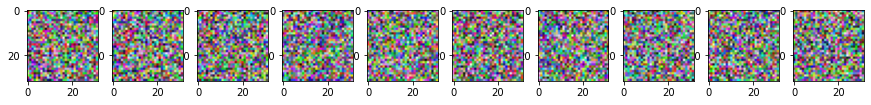

[Epoch 0/600] [Batch 27/386][Loss: 0.332814] ETA: 1 day, 3:03:21.6873421

KeyboardInterrupt: 

In [8]:
T = 300
betas = linear_beta_schedule(timesteps=T)
IMG_SIZE=32



# 预先计算闭合形式的不同项
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
prev_time = time.time()

for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_loader):
        x=Variable(batch).cuda()
        t = torch.randint(0, T, (batch_size,), device=device).long()
        loss = get_loss(model, x, t)
        
             
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batches_done = epoch * len(train_loader) +step
        batches_left = epochs * len(train_loader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()
        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d][Loss: %f] ETA: %s"
            % (
                epoch,
                epochs,
                step,
                len(train_loader),
                loss.item(),
                time_left,
            )
        )
        
        
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image(model,IMG_SIZE=32)